In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.

from importlib.metadata import version
import cv2
import pixellib
import numpy as np
import os
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation
print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [2]:
#분리모델 로딩
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_segmentation = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model_segmentation.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = np.array([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
colormap[:, [0, 2]] = colormap[:, [2, 0]]#1열 3열 바꾸기 RGB->BGR

In [3]:
#이미지 배경을 흐리게 
#category는 LABEL_NAMES에 있는것만
def ShallowFocus(img_path,category) :
    segvalues, output = model_segmentation.segmentAsPascalvoc(img_path)#이미지 세그멘트
    indices = np.where(LABEL_NAMES == category)[0]#원하는 카테고리 인덱스
    if(indices<0) :
        print('잘못된 category입니다')
        print(LABEL_NAMES)
        return
    if indices not in segvalues['class_ids'] :
        print(category+'는 찾지 못했습니다.')
        return
    seg_map = np.all(output==colormap[indices], axis=-1)#해당카테고리 칼러맵을 이용하여 분리 맵 만들기
    img_orig = cv2.imread(img_path)#원본이미지
    img_bg_blur,img_mask_color = blurAndMask(seg_map,img_orig)#blur된 백그라운드 및 이미지마스크 3채널변환 
    stickObject(img_orig, img_bg_blur,img_mask_color)#오브젝트 합성
    plt.imshow(seg_map, cmap='gray')
    plt.show()
    

In [4]:
def blurAndMask(seg_map,img_orig) :
    img_mask = seg_map.astype(np.uint8) * 255
    
    img_orig_blur = cv2.blur(img_orig, (13,13))# (13,13)은 blurring kernel size를 뜻합니다
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.show()
    return img_bg_blur,img_mask_color

    

In [5]:
def stickObject(img_orig, img_bg_blur, img_mask_color) :
    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
    # 아닌 영역은 블러된 이미지 값을 사용합니다.
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    # plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original')
    axes[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[1].set_title('ShallowFocus')

#     plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

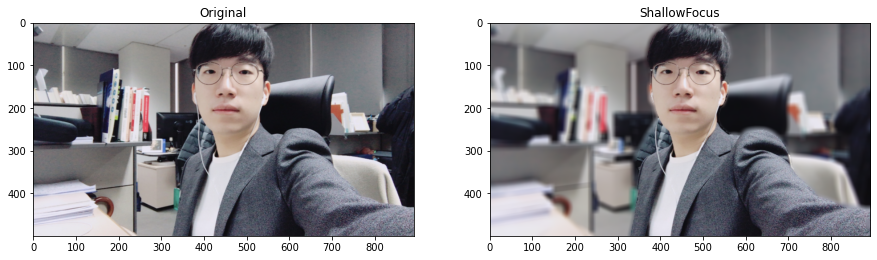

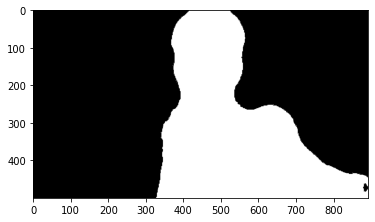

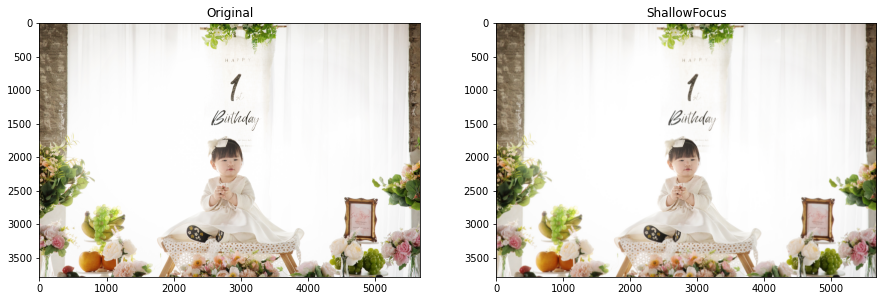

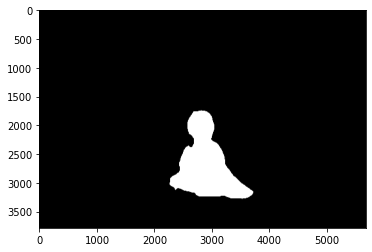

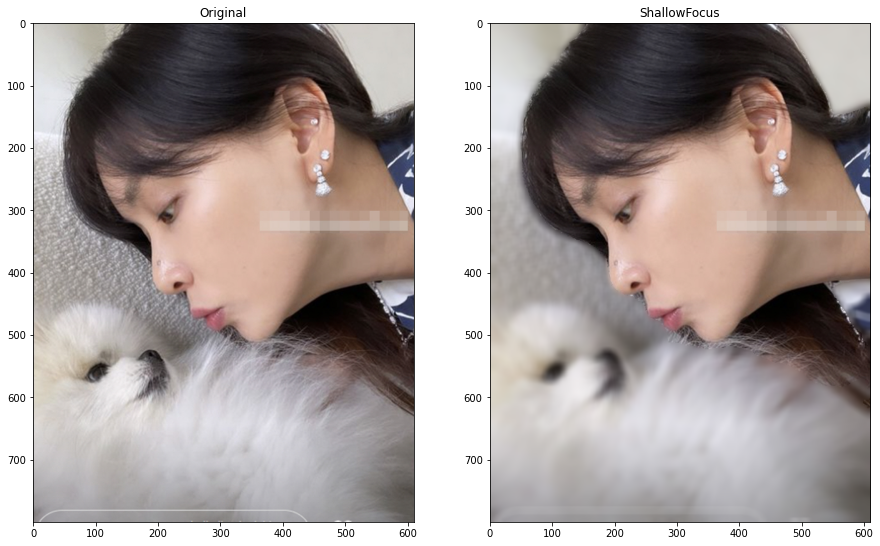

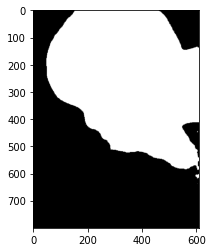

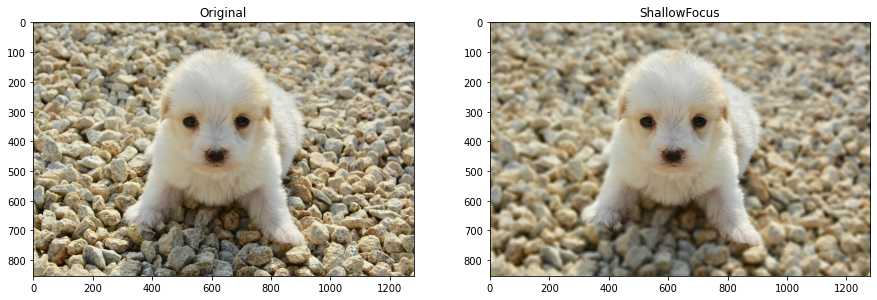

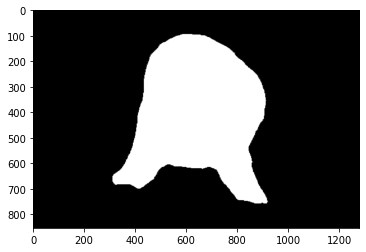

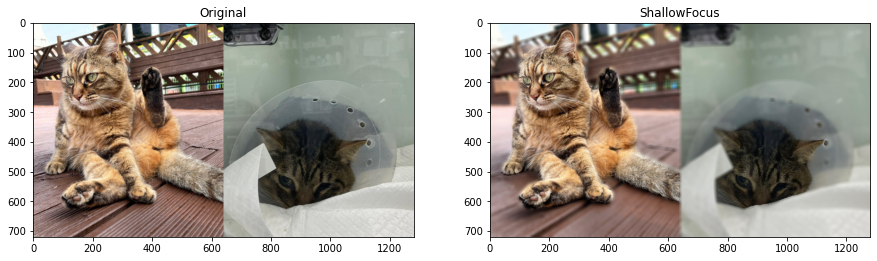

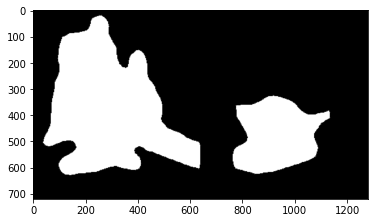

In [6]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
ShallowFocus(img_path,'person')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/AMI7A2923.jpg'  
ShallowFocus(img_path,'person')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/2023052301001718300216831_20230522151304229.jpg'  
ShallowFocus(img_path,'person')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg'  
ShallowFocus(img_path,'dog')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
ShallowFocus(img_path,'cat')

In [24]:
#다른 배경으로 크로마키하기
def ChromaKey(img_path, img_bg_path,category) :
    segvalues, output = model_segmentation.segmentAsPascalvoc(img_path)#이미지 세그멘트
    indices = np.where(LABEL_NAMES == category)[0]#원하는 카테고리 인덱스
    if(indices<0) :
        print('잘못된 category입니다')
        print(LABEL_NAMES)
        return
    if indices not in segvalues['class_ids'] :
        print(category+'는 찾지 못했습니다.')
        return
    seg_map = np.all(output==colormap[indices], axis=-1)#해당카테고리 칼러맵을 이용하여 분리 맵 만들기
    img_orig = cv2.imread(img_path)#원본이미지
    img_bg = cv2.imread(img_bg_path)#배경이미지
    img_bg = cv2.resize(img_bg, (img_orig.shape[1],img_orig.shape[0]))
    img_mask = seg_map.astype(np.uint8) * 255
    kernel = np.ones((5, 5), np.uint8)
    img_mask = cv2.dilate(img_mask, kernel, iterations=3)
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    stickObject(img_orig, img_bg,img_mask_color)#오브젝트 합성

  
크로마키를 해보자

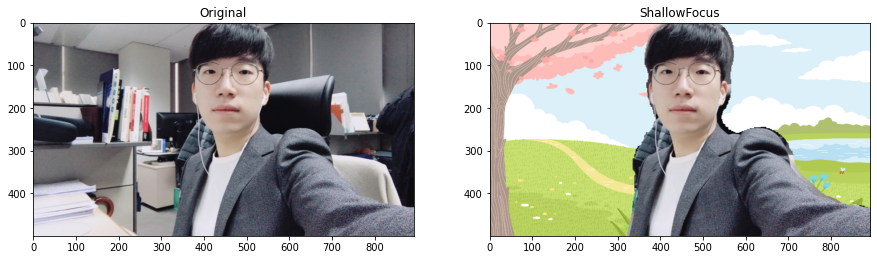

In [25]:
ChromaKey(os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png', os.getenv('HOME')+'/aiffel/human_segmentation/images/6588504.jpg','person')

>사진에서 문제점 찾기



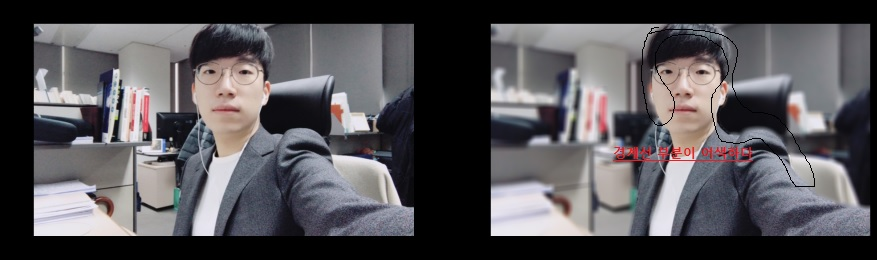

In [9]:
from IPython.display import Image

Image(os.getenv('HOME')+'/aiffel/human_segmentation/images/aa.jpg')

# 해결방안
1. dilate연산을 통한 객체크기를 늘리는 방법

In [22]:
def blurAndMask(seg_map,img_orig) :
    img_mask = seg_map.astype(np.uint8) * 255
    # dilate 연산 적용
    kernel = np.ones((5, 5), np.uint8)
    img_mask = cv2.dilate(img_mask, kernel, iterations=2)

    img_orig_blur = cv2.blur(img_orig, (13,13))# (13,13)은 blurring kernel size를 뜻합니다
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.show()
    return img_bg_blur,img_mask_color

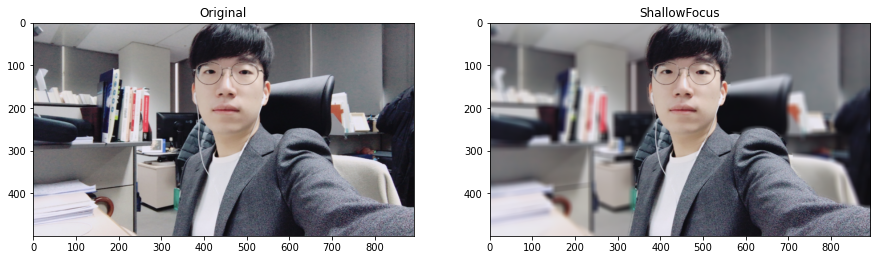

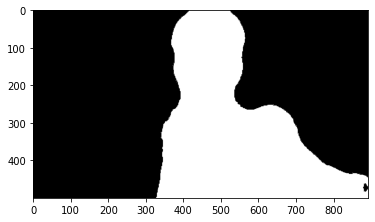

In [23]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
ShallowFocus(img_path,'person')

# 해결방안
2. erode연산을 통한 객체크기를 줄이는 방법

In [18]:
def blurAndMask(seg_map,img_orig) :
    img_mask = seg_map.astype(np.uint8) * 255
    # erode 연산 적용
    kernel = np.ones((15, 15), np.uint8)
    img_mask = cv2.erode(img_mask, kernel, iterations=1)

    img_orig_blur = cv2.blur(img_orig, (13,13))# (13,13)은 blurring kernel size를 뜻합니다
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.show()
    return img_bg_blur,img_mask_color

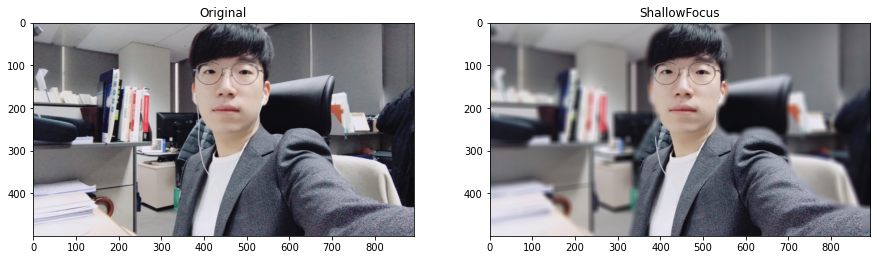

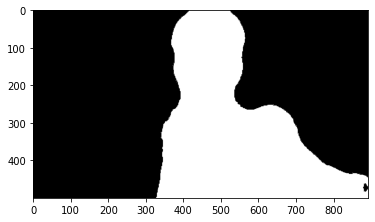

In [19]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
ShallowFocus(img_path,'person')